In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1cf4a822740>,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0}

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#most_recent_date = [i[0] for i in most_recent]
#most_recent_date
most_recent


('2017-08-23',)

In [ ]:
# Importing the datedelta package
import datedelta as dd

2016-08-23


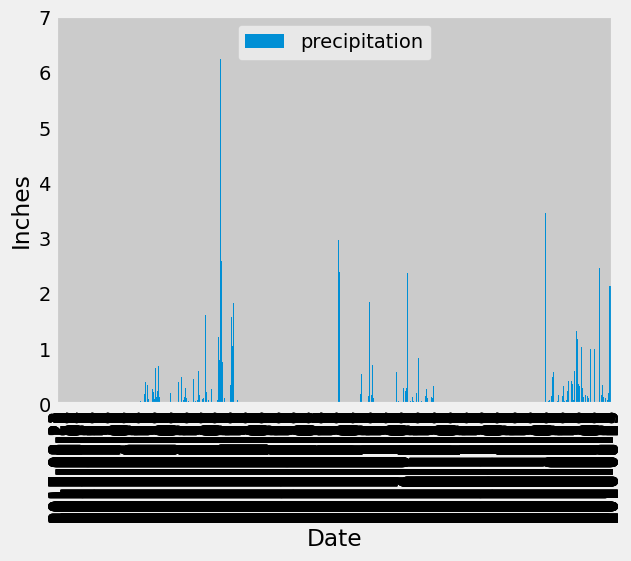

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date_limit = dt.date(2017, 8, 23) - 12 * dd.MONTH
print(query_date_limit)

# Perform a query to retrieve the data and precipitation scores
one_yr_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= query_date_limit).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_yr_data, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
#Sorted in the query above

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(xlabel = 'Date', ylabel = 'Inches', rot=90)
#plt.tight_layout
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1cf4a822aa0>,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [15]:
# Getting a list of Station class column names and types
inspector = inspect(engine)
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Getting a list of Measurement class column names and types
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()


[(9,)]

In [27]:
# importing the desc package to use it in the following cell
from sqlalchemy import desc

In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id).label("total")).\
    group_by(Measurement.station).order_by(desc("total")).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Getting the station id that has the greatest number of observations 
# and storing it into a variable along with its count. The variable will used in the following cell
greatest_station = session.query(Measurement.station, func.count(Measurement.id).label("total")).\
    group_by(Measurement.station).order_by(desc("total")).first()
greatest_station

('USC00519281', 2772)

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
greatest_station_temps = session.query(*sel).filter(Measurement.station == greatest_station[0]).\
    group_by(Measurement.station).all()

print(f"The station with the most observation is {greatest_station[0]}, with lowest, highest and average temperature as follow {greatest_station_temps[0]} respectively")

[(54.0, 85.0, 71.66378066378067)]

In [52]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
most_active_station_recent_yr = session.query(Measurement.tobs).\
    filter(Measurement.station == greatest_station[0]).filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= query_date_limit).all()
df1 = pd.DataFrame(most_active_station_recent_yr, columns=['tobs'])
df1

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


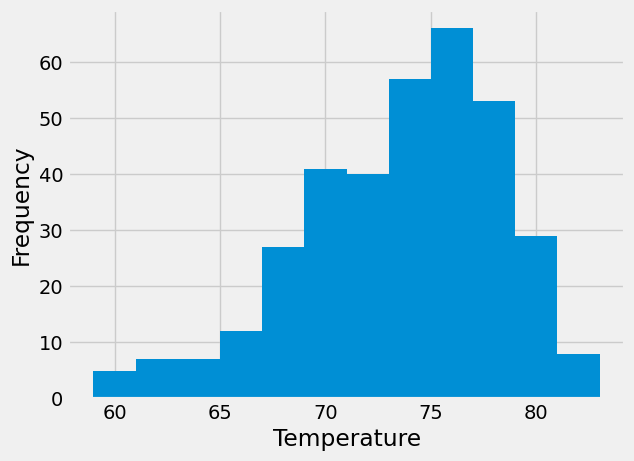

In [58]:
# Plot the above results as a histogram with bins=12
plt.hist(df1, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [85]:
sel = [func.min(Measurement.tobs).label("tmin"),
       func.avg(Measurement.tobs).label("tavg"),
       func.max(Measurement.tobs).label("tmax")]
tobs_by_date = session.query(Measurement.date, *sel).\
    group_by(Measurement.date).all()
#tobs_by_date_list = list(np.ravel(tobs_by_date))
tobs_by_date

[('2010-01-01', 65.0, 69.71428571428571, 75.0),
 ('2010-01-02', 61.0, 67.0, 75.0),
 ('2010-01-03', 67.0, 74.0, 77.0),
 ('2010-01-04', 72.0, 75.0, 76.0),
 ('2010-01-05', 73.0, 74.5, 76.0),
 ('2010-01-06', 71.0, 73.33333333333333, 76.0),
 ('2010-01-07', 68.0, 70.42857142857143, 74.0),
 ('2010-01-08', 63.0, 65.57142857142857, 73.0),
 ('2010-01-09', 67.0, 68.57142857142857, 70.0),
 ('2010-01-10', 70.0, 72.71428571428571, 75.0),
 ('2010-01-11', 64.0, 66.71428571428571, 72.0),
 ('2010-01-12', 57.0, 61.57142857142857, 68.0),
 ('2010-01-13', 57.0, 61.5, 68.0),
 ('2010-01-14', 65.0, 66.42857142857143, 69.0),
 ('2010-01-15', 56.0, 64.83333333333333, 69.0),
 ('2010-01-16', 65.0, 67.33333333333333, 71.0),
 ('2010-01-17', 64.0, 68.0, 70.0),
 ('2010-01-18', 70.0, 73.0, 77.0),
 ('2010-01-19', 61.0, 69.42857142857143, 75.0),
 ('2010-01-20', 66.0, 67.85714285714286, 72.0),
 ('2010-01-21', 68.0, 69.5, 71.0),
 ('2010-01-22', 60.0, 63.5, 67.0),
 ('2010-01-23', 67.0, 73.83333333333333, 78.0),
 ('2010-01-24

In [88]:
tobs_by_date_dict = dict()
for Measurement.date, tmin, tavg, tmax in tobs_by_date:
    tobs_by_date_dict.setdefault(Measurement.date, []).append(tmin)
    tobs_by_date_dict.setdefault(Measurement.date, []).append(tavg)
    tobs_by_date_dict.setdefault(Measurement.date, []).append(tmax)
print(tobs_by_date_dict)


{'2010-01-01': [65.0, 69.71428571428571, 75.0], '2010-01-02': [61.0, 67.0, 75.0], '2010-01-03': [67.0, 74.0, 77.0], '2010-01-04': [72.0, 75.0, 76.0], '2010-01-05': [73.0, 74.5, 76.0], '2010-01-06': [71.0, 73.33333333333333, 76.0], '2010-01-07': [68.0, 70.42857142857143, 74.0], '2010-01-08': [63.0, 65.57142857142857, 73.0], '2010-01-09': [67.0, 68.57142857142857, 70.0], '2010-01-10': [70.0, 72.71428571428571, 75.0], '2010-01-11': [64.0, 66.71428571428571, 72.0], '2010-01-12': [57.0, 61.57142857142857, 68.0], '2010-01-13': [57.0, 61.5, 68.0], '2010-01-14': [65.0, 66.42857142857143, 69.0], '2010-01-15': [56.0, 64.83333333333333, 69.0], '2010-01-16': [65.0, 67.33333333333333, 71.0], '2010-01-17': [64.0, 68.0, 70.0], '2010-01-18': [70.0, 73.0, 77.0], '2010-01-19': [61.0, 69.42857142857143, 75.0], '2010-01-20': [66.0, 67.85714285714286, 72.0], '2010-01-21': [68.0, 69.5, 71.0], '2010-01-22': [60.0, 63.5, 67.0], '2010-01-23': [67.0, 73.83333333333333, 78.0], '2010-01-24': [71.0, 73.16666666666

# Close session

In [59]:
# Closing Session
session.close()